## 모듈러티 모멘텀 동일 비중 포트폴리오
### 장단기 금리 역전 상황

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings

from matplotlib import ticker
warnings.filterwarnings(action='ignore')
import networkx as nx
import community as community_louvain

In [17]:
from capstone.util import load_dataset
from modularity.util import load_kospi_data

pickle_path = '../pickle'
kospi_path = '../data/kospi200_stocks.xlsx'

yield_curve_inversion = {
    "name" : "yield_curve_inversion",
    "start_date" : '2018-01-01',
    "end_date": '2019-12-01'
}

kospi_pickle_path = pickle_path + '/kospi_data.pickle'
kospi_data = load_kospi_data(kospi_pickle_path,kospi_path)
yield_curve_inversion_pickle_path = pickle_path + f'/{yield_curve_inversion["name"]}.pickle'

df_yield_curve = load_dataset(kospi_data,yield_curve_inversion_pickle_path,yield_curve_inversion['start_date'],yield_curve_inversion['end_date'])

In [18]:
# yield curve reversed
test_df = df_yield_curve[:'2019-01-01']
validation_df = df_yield_curve['2019-01-02':]

In [19]:
from modularity.calculate_modularity import calculate_louvain
from community import community_louvain

partition,G = calculate_louvain(test_df,threshold=0.30)
modularity_value = community_louvain.modularity(partition,G)
print(f"MODULARITY : {modularity_value}")

n_clusters = len(set(partition.values()))
print(f"클러스터 갯수 : {n_clusters}")

# 클러스터 개수만큼 딕셔너리 생성
dict_clusters = {i : [] for i in range(n_clusters)}

MODULARITY : 0.1269136352097474
클러스터 갯수 : 2


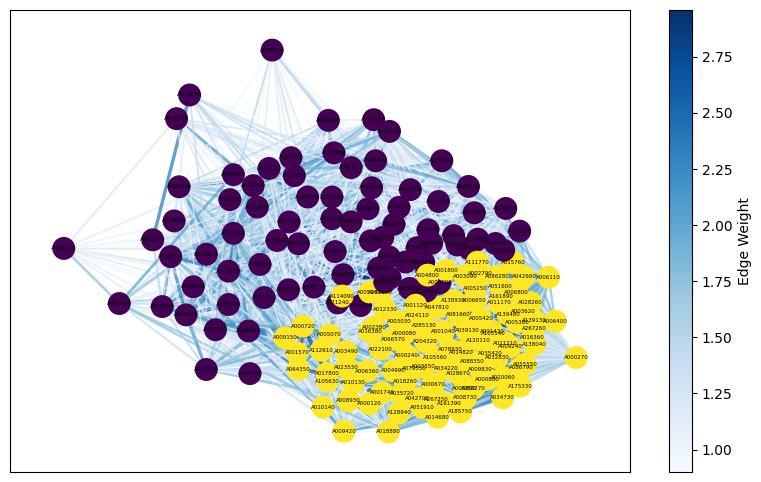

In [20]:
from capstone.util import visualize_edge_graph

visualize_edge_graph(G,partition)

In [21]:
# 클러스터 기준으로 군집 분류 
for stock_code,cluster in partition.items():
    dict_clusters[cluster].append(stock_code)

# 각 군집별로 데이터프레임 생성
clusters_list = []
for cluster in dict_clusters.keys():
    clusters_list.append(df_yield_curve[dict_clusters[cluster]])

# validation 각 군집별로 데이터프레임 생성
val_clusters_list = []
for cluster in dict_clusters.keys():
    val_clusters_list.append(validation_df[dict_clusters[cluster]])

In [22]:
import statsmodels.api as sm

def make_top_20_all_clusters(clusters_list:list)->list:
    top_20_stocks = {}

    # 각 클러스터 별로 K-ratio 계산 및 랭킹 매기기  
    for idx, df_cluster in enumerate(clusters_list):
        # 종목 코드 리스트
        ticker_list = df_cluster.columns

        # 일별 수익률 계산
        returns = df_cluster.pct_change().iloc[1:]
        # 누적 로그 수익률 
        cum_returns = np.log(1 + returns).cumsum()
        # X축 : 기간 
        x = np.array(range(len(returns)))
        K_ratio = {}

        for ticker in ticker_list:
            try:
                y = cum_returns[ticker].values
                # OLS 회귀 분석
                reg = sm.OLS(y, sm.add_constant(x)).fit()
                # K- ratio
                result = float(reg.params[1] / reg.bse[1])
            except:
                result = np.nan
            K_ratio[ticker] = result

        # K-ratio를 데이터 프레임으로 변환
        df_k_ratio = pd.DataFrame.from_dict(K_ratio, orient='index').reset_index()
        df_k_ratio.columns = ['종목코드', 'K_ratio']

        # K-ratio에 따라 종목을 랭킹 
        df_k_ratio['K_ratio_rank'] = df_k_ratio['K_ratio'].rank(axis=0, ascending=False)
        # 상위 n개 종목 추출(10,20,30) 
        top_20 = df_k_ratio[df_k_ratio['K_ratio_rank'] <= 10]
        top_20_stocks[f'cluster_{idx}'] = top_20

    top_20_all_clusters = []
    for cluster_df in top_20_stocks.values():
        top_20_all_clusters.extend(cluster_df['종목코드'].tolist())

    top_20_all_clusters = list(set(top_20_all_clusters))
    return top_20_all_clusters

In [23]:
# 상위 n개의 종목을 합치고 중복을 제거
top_20_all_clusters = make_top_20_all_clusters(clusters_list)

# dataset_1st_year에서 상위 n개 종목들만 추출 
df_momentum = df_yield_curve[top_20_all_clusters]

In [24]:
from capstone.portfolio_model import equal_weighting_portfolio

portfolio_daily_return,portfolio_cum_return = equal_weighting_portfolio(kospi_data, df_momentum, '2019-01-02','2019-12-01')

2019-01-02부터 2019-12-01 까지 동일 비중 투자 누적 수익률 : 16.87%


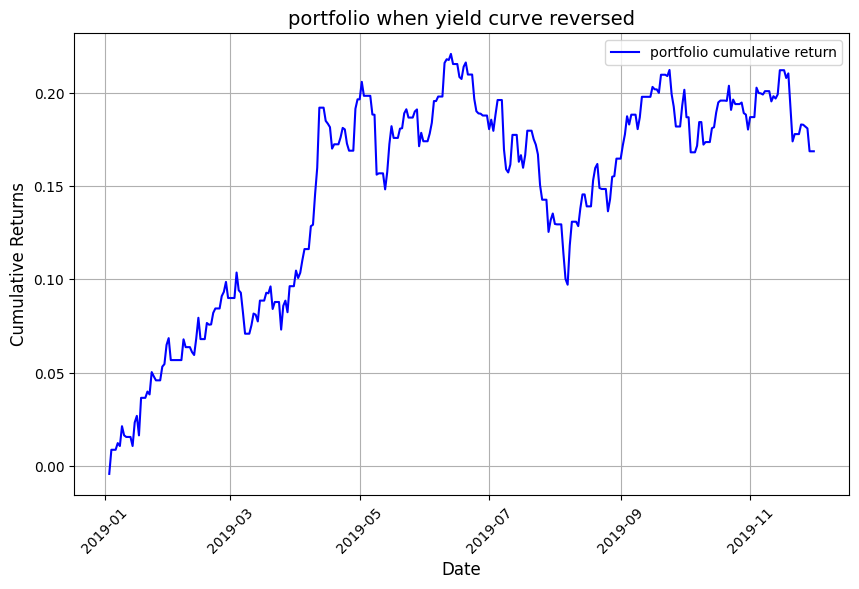

In [25]:
from capstone.display import plot_portfolio

increase_rate_info = {
    "title" : "portfolio when yield curve reversed",
    "start_date" : '2019-01-02',
    "end_date" : "2019-12-01",
    "save_url" : f"../fig/yield_curve_reverse/eq/momentum",
    "data_df" : portfolio_cum_return,
}
plot_portfolio(**increase_rate_info)

In [26]:
from capstone.evaluate_index import calculate_sharpe, calculate_sortino

샤프지수 = calculate_sharpe(portfolio_daily_return)
소프타노지수 = calculate_sortino(portfolio_daily_return)

print(f"샤프지수 : {샤프지수}")
print(f"소프타노 지수 : {소프타노지수}")


샤프지수 : 0.8783174357205614
소프타노 지수 : 0.7353573485717563


## 같은 기간 KOSPI와 비교

In [27]:
kospi_cum_returns = pd.read_pickle("../pickle/201801_201912_CUM_KOSPI_200.pickle")

compare_with_kospi_info = {
    "title": "compare with benchmark when yield curve reversed",
    "start_date" : '2019-01-02',
    "end_date" : "2019-12-01",
    "save_url" : "../fig/yield_curve_reverse/eq/momentum",
    "portfolio_df" : portfolio_cum_return,
    "kospi_df" : kospi_cum_returns
    
}

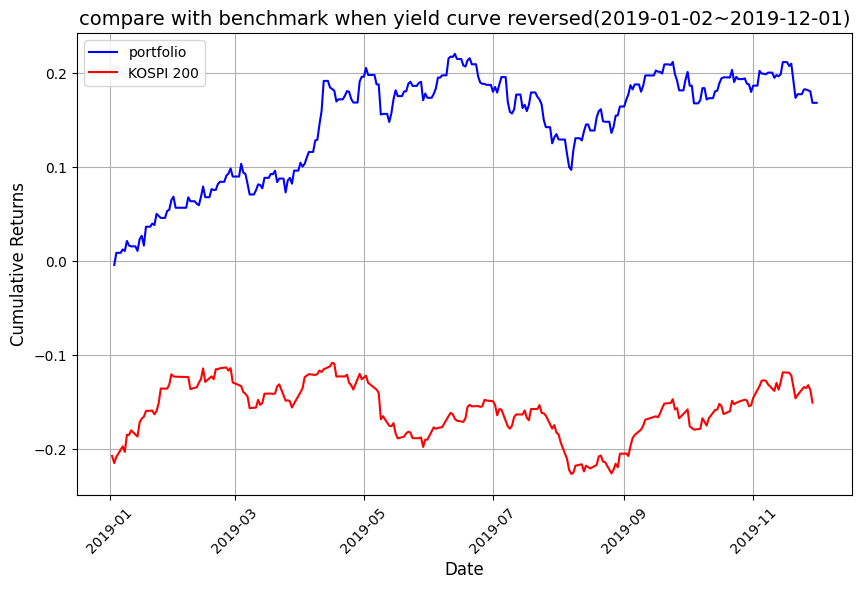

In [28]:
from capstone.display import compare_with_benchmark

compare_with_benchmark(**compare_with_kospi_info)

In [29]:
kospi_cum_returns[-1]

-0.1509815988365144

In [30]:
portfolio_cum_return[-1]

0.1686703544878687